<a href="https://colab.research.google.com/github/NikhilR068/Text-inpainting/blob/master/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

input_image.shape:  (512, 512, 3)


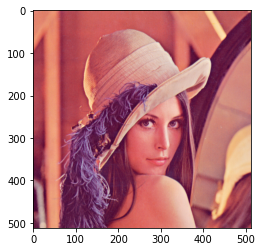

In [ ]:
import os, time
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
input_path = 'lenna_ori.png'
output_path = ''
 
input_image = np.array(Image.open(input_path))
print('input_image.shape: ', input_image.shape)
plt.imshow(input_image)

In [ ]:
from google.colab import files
x = files.upload()

Saving FreeSansBold.ttf to FreeSansBold.ttf
Saving lenna_ori.png to lenna_ori.png


In [ ]:
def reflect_padding_layer(tf_input_image, kernel_size, stride):

    input_size = int(tf_input_image.get_shape()[1])
    output_size = int(np.ceil(input_size / stride))

    pad_size = int(np.ceil(((output_size - 1) * stride + kernel_size - input_size) * 0.5))
    print('pad size:', pad_size)
    tf_input_image = tf.pad(tf_input_image, 
                            [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], 
                            "REFLECT")
    
    return tf_input_image


def get_binary_text_mask(for_image, sz=20, position=(128, 128), text='hello world'):

    """
    refer from:
    https://github.com/DmitryUlyanov/deep-image-prior/blob/master/utils/inpainting_utils.py

    """

    font_fname = 'FreeSansBold.ttf'
    font_size = sz
    font = ImageFont.truetype(font_fname, font_size)
    img_mask = Image.fromarray(np.array(for_image)*0+255)
    draw = ImageDraw.Draw(img_mask)
    draw.text(position, text, font=font, fill='rgb(0, 0, 0)')

    binary_mask_temp = np.array(img_mask)
    binary_mask = np.zeros_like(binary_mask_temp, dtype=np.float32)
    binary_mask += 1.0
    binary_mask[binary_mask_temp<254] -= 1.0

    return binary_mask

In [ ]:
def downsampling_layer(tf_input_image, n_d=128, k_d=7):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_d, stride=2)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=2, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_d, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)
    
    return tf_input_image


def upsampling_layer(tf_input_image, n_u=128, k_u=7):

    height, width = tf_input_image.get_shape()[1:3]
    tf_input_image = tf.image.resize_images(tf_input_image, [height*2, width*2], 
                                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_u, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=k_u, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    # kernel_size=1
    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=1, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=1, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    return tf_input_image
def skip_connections_layer(tf_input_image, n_s=0, k_s=0):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_s, stride=1)
    tf_input_image_sc = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_s, 
                                                 kernel_size=k_s, stride=1, 
                                                 padding='VALID', activation_fn=None)
    tf_input_image_sc = tf.contrib.layers.batch_norm(inputs=tf_input_image_sc, 
                                                     activation_fn=tf.nn.leaky_relu)

    ## use concat
    tf_input_image = tf.concat([tf_input_image, tf_input_image_sc], axis=3)

    return tf_input_image



def for_output_layer(tf_input_image, n_o=3, k_o=1):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_o, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_o, 
                                              kernel_size=k_o, stride=1, 
                                              padding='VALID', activation_fn=None)
    return tf_input_image


def image_save(path, img, reshape_size=[512, 512, 3]):
    img = np.array(img)
    img = img.reshape(reshape_size)
    img = np.clip(img, 0, 255).astype(np.uint8)
    Image.fromarray(img).save(path, quality=95)


In [ ]:
def run(input_image, n_u_list, n_d_list, k_u_list, k_d_list, n_s_list, k_s_list,
                    LR, num_iter, save_every_iter, show_every_iter, output_path, output_file_name,
                    image_normalize_TF, sigmoid_TF):

    output_temp_path = output_path + 'temp/'

    
    image_shape = [shape for shape in input_image.shape[:-1]]
    output_image_shape = [1] + image_shape + [32]

    ## get mask
    binary_mask_1 = get_binary_text_mask(input_image, sz=30, position=(128, 128), 
                                         text='Hello World')
    binary_mask_2 = get_binary_text_mask(input_image, sz=25, position=(250, 300), 
                                         text='on the face')
    binary_mask = np.multiply(binary_mask_1, binary_mask_2)

    corrupted_image = np.multiply(input_image, binary_mask)
    corrupted_image = corrupted_image.astype(np.uint8)

    ## show image
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('original_image')
    ax1.imshow(input_image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('binary_mask')
    ax2.imshow(binary_mask)
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('corrupted_image')
    ax3.imshow(corrupted_image)
    plt.show()
    


    ## graph  (can improve here !!)
    print('image_normalize_TF: ', image_normalize_TF)  
    print('sigmoid_TF: ', sigmoid_TF)  
    print('\nmodel structure: ')
    input_image_shape = [1] + image_shape + [3]
    input_image = corrupted_image
    if image_normalize_TF:
        input_image = input_image / 255
    input_image = np.reshape(input_image, input_image_shape)    
    input_image = tf.constant(input_image, dtype=tf.float32)
    print(output_image_shape)
    ## placeholder
    output_image_point = tf.placeholder(shape=output_image_shape, dtype=tf.float32)
    tf_binary_mask = tf.placeholder(shape=input_image_shape[1:], dtype=tf.float32) 

    output_image = output_image_point
    print(output_image.shape)
    ## downsampling
    for i in range(len(n_d_list)):
        output_image = downsampling_layer(tf_input_image=output_image, 
                                          n_d=n_d_list[i], k_d=k_d_list[i])
        print(output_image.get_shape())

    ## skip_connections
    output_image = skip_connections_layer(output_image, n_s=n_s_list[-1], k_s=k_s_list[-1])
    print(output_image.get_shape())

    ## upsampling   ** reversed !
    for i in reversed(range(len(n_u_list))):
        output_image = upsampling_layer(tf_input_image=output_image, 
                                        n_u=n_u_list[i], k_u=k_u_list[i])
        print(output_image.get_shape())

    ## for output
    output_image = for_output_layer(tf_input_image=output_image, n_o=3, k_o=1)
    print(output_image.get_shape())

    if sigmoid_TF:
        output_image = tf.sigmoid(output_image)

    ## loss, E()
    tf_binary_mask_ = tf.expand_dims(tf_binary_mask, 0)
    loss_E = tf.reduce_mean(tf.square(tf.multiply(tf.subtract(output_image, input_image), 
                                                  tf_binary_mask_)))
    optimizer = tf.train.AdamOptimizer(learning_rate=LR)
    train_op = optimizer.minimize(loss_E)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())

        ## training
        print('\nGo Training...')
        training_start_time = time.time()
        iter_start_time = time.time()
        z = np.random.uniform(low=0.0, high=1/10, size=output_image_shape) 

        for i in range(num_iter+1):
            # z = np.random.uniform(low=0.0, high=1/10, size=output_image_shape)
            using_dict = {output_image_point: z, tf_binary_mask: binary_mask}

            ## run here
            sess.run(train_op, feed_dict=using_dict)

            if i % save_every_iter == 0:
                generate_image, training_loss = sess.run([output_image, loss_E], 
                                                         feed_dict=using_dict)
                generate_image = generate_image[0]

                if image_normalize_TF:
                    generate_image = generate_image * 255
                generate_image = np.clip(generate_image, 0, 255).astype(np.uint8)

                output_file = output_temp_path + output_file_name + '_' + str(i) + '.png'
            
                print('iter: {:4d}/{:4d}, training loss: {:.8f}, use time: {:.3f}'.
                      format(i, num_iter, training_loss, time.time()-iter_start_time))
                iter_start_time = time.time()

            if i % show_every_iter == 0:
                fig = plt.figure(figsize=(8, 8))
                ax1 = fig.add_subplot(1,2,1)
                ax1.set_title('corrupted_image')
                ax1.imshow(corrupted_image)
                ax2 = fig.add_subplot(1,2,2)
                ax2.set_title('generate_image')
                ax2.imshow(generate_image)
                plt.show()
        output_file = output_path + output_file_name + '_' + str(i) + '_final.png'
        
        print('training OK! (total using time: {})'.format(time.time()-training_start_time))

        plt.imshow(generate_image)
        plt.show()

        return generate_image

In [ ]:
from google.colab import files
x = files.upload()

KeyboardInterrupt: ignored

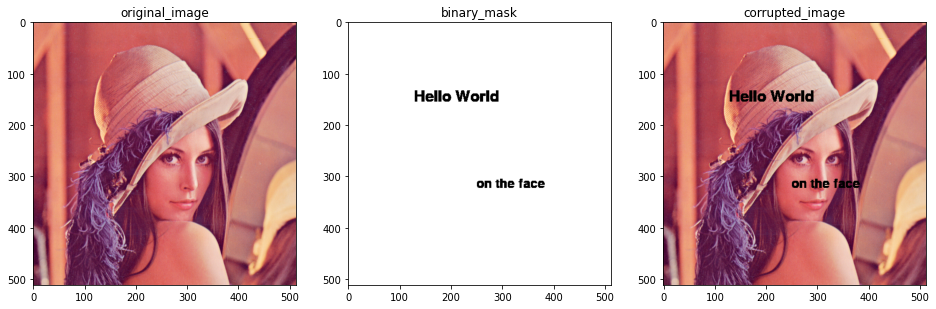

image_normalize_TF:  True
sigmoid_TF:  True

model structure: 
[1, 512, 512, 32]
(1, 512, 512, 32)
pad size: 3
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
pad size: 3
(1, 256, 256, 16)
pad size: 3
pad size: 3
(1, 128, 128, 32)
pad size: 3
pad size: 3
(1, 64, 64, 64)
pad size: 3
pad size: 3
(1, 32, 32, 128)
pad size: 3
pad size: 3
(1, 16, 16, 128)
pad size: 0
(1, 16, 16, 132)
pad size: 3
pad size: 0
(1, 32, 32, 128)
pad size: 3
pad size: 0
(1, 64, 64, 128)
pad size: 3
pad size: 0
(1, 128, 128, 64)
pad size: 3
pad size: 0
(1, 256, 256, 32)
pad size: 3
pad size: 0
(1, 512, 512, 16)
pad size: 0
(1, 512, 51

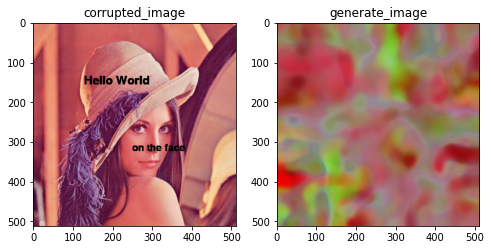

KeyboardInterrupt: ignored

In [ ]:
n_u_list = n_d_list = [16, 32, 64, 128, 128]
k_u_list = k_d_list = [7, 7, 7, 7, 7]
n_s_list = [0, 0, 0, 0, 4]
k_s_list = [0, 0, 0, 0, 1] 
tf.compat.v1.disable_eager_execution()
LR = 0.01   ## learning rate
num_iter = 3000
save_every_iter = 50
show_every_iter = 500
output_path = './pic_output/'
output_file_name = 'lenna_ti'

## some TF setting
image_normalize_TF = True
sigmoid_TF = True


ok_image = run(input_image, n_u_list, n_d_list, 
                           k_u_list, k_d_list, n_s_list, k_s_list, 
                           LR, num_iter, save_every_iter, 
                           show_every_iter, output_path, output_file_name, 
                           image_normalize_TF, sigmoid_TF)

In [ ]:
model.summary

NameError: ignored